In [4]:
#used this file
# STACKING ENSEMBLE WITH TABNET AS META MODEL


# 1️⃣ Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                           recall_score, f1_score, roc_auc_score, roc_curve, 
                           precision_recall_curve, average_precision_score)
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch  # Import PyTorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb 



In [5]:

# 2️⃣ Load Dataset (Final Preprocessed CSV)
df = pd.read_csv("D:/FYP/data/datasets/final_dataset_02.csv")

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label'].astype(int)


In [6]:
# 3️⃣ Load Trained Base Models (Native API models saved with joblib)
base_model_paths = {
    "xgboost": "D:/FYP/models/trained_models/xgboost_native_model.pkl",
    "lightgbm": "D:/FYP/models/trained_models/lightgbm_intrusion_detection.pkl",
    "catboost": "D:/FYP/models/trained_models/catboost_intrusion_detection.pkl"
}

xgb_model = joblib.load(base_model_paths["xgboost"])
lgb_model = joblib.load(base_model_paths["lightgbm"])
#cat_model = joblib.load(base_model_paths["catboost"]) #due to catboost is not installed in my system, so I commented this line

In [7]:
# 4️⃣ Split Dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
# 5️⃣ Generate Base Model Predictions (as meta-features)
# XGBoost (Native API expects DMatrix)
xgb_train_dmatrix = xgb.DMatrix(X_train)
xgb_test_dmatrix = xgb.DMatrix(X_test)
xgb_train_preds = xgb_model.predict(xgb_train_dmatrix)
xgb_test_preds = xgb_model.predict(xgb_test_dmatrix)

# LightGBM (predict_proba returns 2 columns: [prob_class_0, prob_class_1])
# lgb_train_preds = lgb_model.predict_proba(X_train)[:, 1]
# lgb_test_preds = lgb_model.predict_proba(X_test)[:, 1]

#used this due to native api
lgb_train_preds = lgb_model.predict(X_train)  
lgb_test_preds = lgb_model.predict(X_test)


# CatBoost (predict_proba returns 2 columns as well)
#cat_train_preds = cat_model.predict_proba(X_train)[:, 1]
#cat_test_preds = cat_model.predict_proba(X_test)[:, 1]

# Combine base model outputs as meta-features for TabNet   # will use this when catboost is installed
# X_meta_train = np.vstack((xgb_train_preds, lgb_train_preds, cat_train_preds)).T
# X_meta_test = np.vstack((xgb_test_preds, lgb_test_preds, cat_test_preds)).T

# Combine base model other than catboost outputs as meta-features for TabNet
X_meta_train = np.vstack((xgb_train_preds, lgb_train_preds)).T
X_meta_test = np.vstack((xgb_test_preds, lgb_test_preds)).T

In [11]:
# 6️⃣ Normalize Meta-Features
scaler = StandardScaler()
X_meta_train_scaled = scaler.fit_transform(X_meta_train)
X_meta_test_scaled = scaler.transform(X_meta_test)

In [12]:
# 7️⃣ Initialize TabNet Classifier
tabnet_model = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax',
    verbose=10,
    seed=42
)

# 8️⃣ Train TabNet Meta Model
tabnet_model.fit(
    X_meta_train_scaled, y_train.values,
    eval_set=[(X_meta_test_scaled, y_test.values)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=20,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0
)


d:\FYP\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.02715 | valid_accuracy: 1.0     |  0:00:19s
epoch 10 | loss: 0.0001  | valid_accuracy: 1.0     |  0:05:06s
epoch 20 | loss: 0.00017 | valid_accuracy: 0.99996 |  0:09:50s

Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 1.0


d:\FYP\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [13]:
# 9️⃣ Evaluate Meta Model Performance
# 1. Predictions & Probabilities
y_pred = tabnet_model.predict(X_meta_test_scaled)
y_pred_proba = tabnet_model.predict_proba(X_meta_test_scaled)[:, 1]

# 2. Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# 3. Detailed Classification Report
print("\n📊 STATE-OF-THE-ART MODEL EVALUATION METRICS")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall/Sensitivity: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")
print(f" ROC-AUC: {roc_auc:.4f}")
print(f" Average Precision (AP): {average_precision:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))


📊 STATE-OF-THE-ART MODEL EVALUATION METRICS
 Accuracy: 1.0000
 Precision: 1.0000
 Recall/Sensitivity: 1.0000
 F1-Score: 1.0000
 ROC-AUC: 1.0000
 Average Precision (AP): 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13386
           1       1.00      1.00      1.00     13385

    accuracy                           1.00     26771
   macro avg       1.00      1.00      1.00     26771
weighted avg       1.00      1.00      1.00     26771



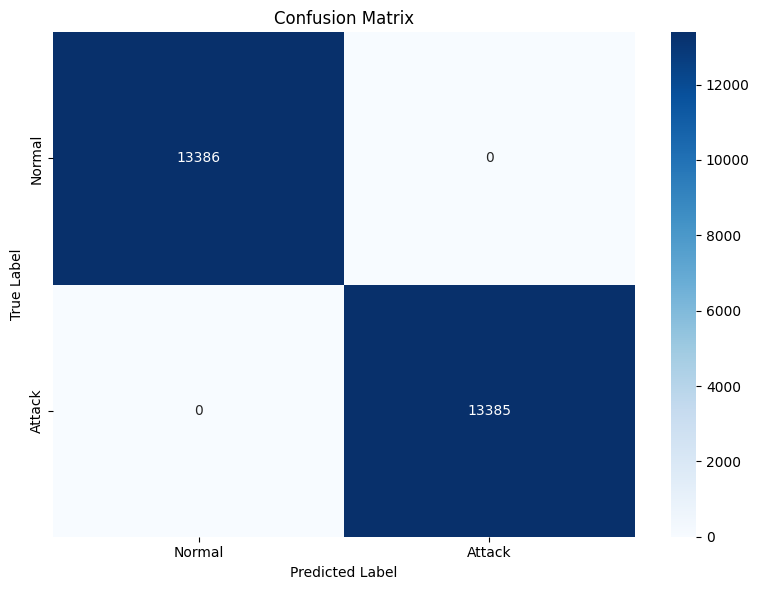

In [14]:
# 4. Confusion Matrix Visualization
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

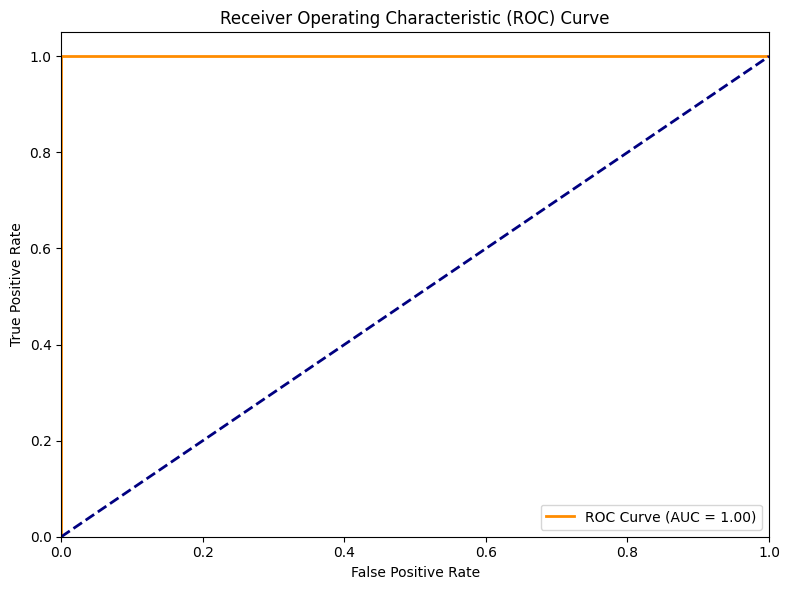

In [15]:
# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

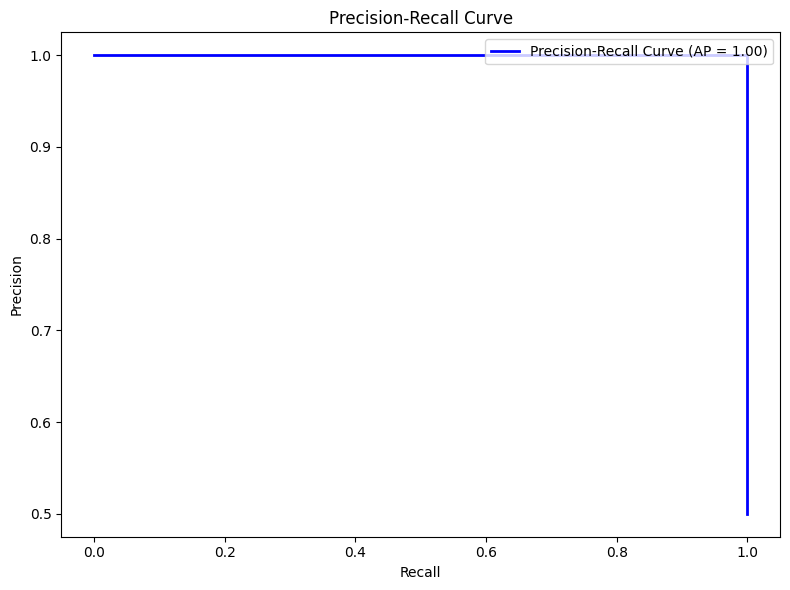

In [16]:
# 6. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2,
         label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [17]:
# 🔟 Save TabNet Meta Model and Scaler
model_dir = "D:/FYP/models/trained_models"
os.makedirs(model_dir, exist_ok=True)

tabnet_path = os.path.join(model_dir, "tabnet_meta_model.pkl")
scaler_path = os.path.join(model_dir, "meta_scaler.pkl")

joblib.dump(tabnet_model, tabnet_path)
print(f"✅ TabNet Meta Model saved at: {tabnet_path}")

joblib.dump(scaler, scaler_path)
print(f"✅ Meta feature scaler saved at: {scaler_path}")

✅ TabNet Meta Model saved at: D:/FYP/models/trained_models\tabnet_meta_model.pkl
✅ Meta feature scaler saved at: D:/FYP/models/trained_models\meta_scaler.pkl
